# Create Size Ground Truth Model from the Pvk experiment data

Hypothesis generation step: Mordred featurization + RFE + random forest regression + Shapley value analysis

Ver 1, 20210921

For the hypothesis generation step, we have put together: Mordred featurization, recursive feature elimination (RFE), random forest regression, and Shapley value analysis.

## Loading dataset

Choose which dataset you want for your your hypothesis generation.

In [1]:
# Import all the packages needed for the notebook to run

# %matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
import re
import rdkit
import numpy as np
import pandas as pd
from pandas import DataFrame, read_csv
from IPython.display import display_html

In [2]:
pattern = r"envs/(.*?)/"
environment_name = re.findall(pattern, sys.argv[0])[0]
print('environment name is :',environment_name)

if not os.path.exists(environment_name):
    os.makedirs(environment_name)

environment name is : leveler2


In [3]:
# Import the perovskite crystal data
modred_data_path = './datasets/mordred_data_2.csv'
data_path = './datasets/combined_compiledData.csv'
os.chdir(os.getcwd()) # 將工作目錄更改為當前工作目錄。
data_Xy = pd.read_csv(data_path)
# Read the dataframe of degradation data
data_Xy = pd.DataFrame(data_Xy)
data_Xy

,SMILES,Reagent1 (ul),Reagent2 (ul),Reagent3 (ul),Reagent4 (ul),Reagent5 (ul),Reagent6 (ul),Reagent7 (ul),Reagent8 (ul),Reagent9 (ul),crystal_score,crystal_size,lab_code
0,Cc1cccc(n1)-c2cccc(C)n2,28,126,4,41,0,0,0,0,800,4.0,1.4593,1
1,Cc1cccc(n1)-c2cccc(C)n2,100,6,41,52,0,0,0,0,800,1.0,0.0000,1
2,Cc1cccc(n1)-c2cccc(C)n2,14,88,18,80,0,0,0,0,800,4.0,0.7670,1
3,Cc1cccc(n1)-c2cccc(C)n2,28,69,83,20,0,0,0,0,800,4.0,0.7070,1
4,Cc1cccc(n1)-c2cccc(C)n2,50,3,89,58,0,0,0,0,800,4.0,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,CC(C)(C)c1ccnc(c1)-c2cc(cc(n2)-c3cc(ccn3)C(C)(...,87,87,11,14,0,0,0,0,800,2.0,0.0000,1
572,CC(C)(C)c1ccnc(c1)-c2cc(cc(n2)-c3cc(ccn3)C(C)(...,3,46,95,56,0,0,0,0,800,1.0,0.0000,1
573,CC(C)(C)c1ccnc(c1)-c2cc(cc(n2)-c3cc(ccn3)C(C)(...,57,88,36,19,0,0,0,0,800,1.0,0.0000,1
574,CC(C)(C)c1ccnc(c1)-c2cc(cc(n2)-c3cc(ccn3)C(C)(...,125,28,23,24,0,0,0,0,800,1.0,0.0000,1


In [4]:
# Only use the one with additives
data_noAdditive = data_Xy[data_Xy['SMILES']!= 'no_additive'] # 條件篩選出沒有添加劑的數據，並將其載入 data_noAdditive 變數中。

# Clean the NaN on crystal score
data_noAdditive = data_noAdditive.dropna(subset=['crystal_score','crystal_size'])

# Separate the X without SMILES (excluding the y)
X_withoutSMILES = data_noAdditive.drop(['crystal_score','crystal_size','SMILES'],axis=1) # 函數刪除 crystal_score 和 crystal_size 列中包含 NaN 值的行。

# Separate the X with SMILES (excluding the y)
X_withSMILES = data_noAdditive.drop(['crystal_score','crystal_size'],axis=1) 
# Assign the crystal size as y
y = data_noAdditive['crystal_size']
y_score = data_noAdditive['crystal_score']
X_withSMILES
print(X_withoutSMILES)

     Reagent1 (ul)  Reagent2 (ul)  Reagent3 (ul)  Reagent4 (ul)  \
0               28            126              4             41   
1              100              6             41             52   
2               14             88             18             80   
3               28             69             83             20   
4               50              3             89             58   
..             ...            ...            ...            ...   
571             87             87             11             14   
572              3             46             95             56   
573             57             88             36             19   
574            125             28             23             24   
575             54             28             62             55   

     Reagent5 (ul)  Reagent6 (ul)  Reagent7 (ul)  Reagent8 (ul)  \
0                0              0              0              0   
1                0              0              0             

## Featurization

Now, we are doing featurization to convert the SMILES from our dataset to Mordred descriptors/ features.

### Using RDkit to generate ROMol

In [5]:
# Import RDkit packages
from rdkit.Chem import PandasTools
from rdkit import Chem

from mordred import Calculator, descriptors


In [6]:
# Indicate where the SMILES is for the ROMol generation
esol_data = X_withSMILES['SMILES']

# Generate ROMol
esol_data = pd.DataFrame(X_withSMILES['SMILES'])
PandasTools.AddMoleculeColumnToFrame(esol_data, smilesCol='SMILES')
esol_data.head(5)

,SMILES,ROMol
0,Cc1cccc(n1)-c2cccc(C)n2,<rdkit.Chem.rdchem.Mol object at 0x7f8f37ad5c30>
1,Cc1cccc(n1)-c2cccc(C)n2,<rdkit.Chem.rdchem.Mol object at 0x7f8f37ad5c90>
2,Cc1cccc(n1)-c2cccc(C)n2,<rdkit.Chem.rdchem.Mol object at 0x7f8f37ad5cf0>
3,Cc1cccc(n1)-c2cccc(C)n2,<rdkit.Chem.rdchem.Mol object at 0x7f8f37ad5d50>
4,Cc1cccc(n1)-c2cccc(C)n2,<rdkit.Chem.rdchem.Mol object at 0x7f8f37ad5db0>


### Incorporating Modred features

You can read more on Mordred descriptors here: 
1. Moriwaki, H., Tian, YS., Kawashita, N. et al. Mordred: a molecular descriptor calculator. J Cheminform 10, 4 (2018). https://doi.org/10.1186/s13321-018-0258-y
2. Mordred descriptors GitHub package: https://github.com/mordred-descriptor/mordred/blob/develop/examples/030-multiple_mol-multiple_desc.py

In [7]:
# Find the unique SMILES, and put them in a list
smiles_unique =((esol_data['SMILES'].unique()).tolist()) # 找到唯一 SMILES
# smiles_list = []
# for i in range(len(smiles_unique)):
#     smiles_list.append(Chem.MolFromSmiles(smiles_unique[i]))

# Create Calculator, and calculate the Mordred descriptors into dataframe for unique SMILES
calc = Calculator(descriptors)
# calc.pandas(smiles_list)

### Add Mordred features into dataframe

Now let's add Mordred into actual dataframe (not only the unique SMILES).

,SMILES,ROMol
0,Cc1cccc(n1)-c2cccc(C)n2,
1,Cc1cccc(n1)-c2cccc(C)n2,
2,Cc1cccc(n1)-c2cccc(C)n2,
3,Cc1cccc(n1)-c2cccc(C)n2,
4,Cc1cccc(n1)-c2cccc(C)n2,
...,...,...
571,CC(C)(C)c1ccnc(c1)-c2cc(cc(n2)-c3cc(ccn3)C(C)(...,
572,CC(C)(C)c1ccnc(c1)-c2cc(cc(n2)-c3cc(ccn3)C(C)(...,
573,CC(C)(C)c1ccnc(c1)-c2cc(cc(n2)-c3cc(ccn3)C(C)(...,
574,CC(C)(C)c1ccnc(c1)-c2cc(cc(n2)-c3cc(ccn3)C(C)(...,

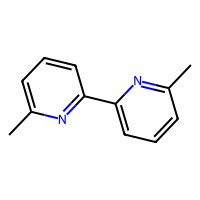
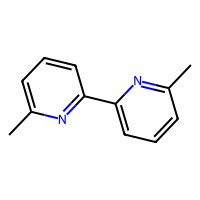
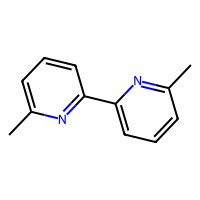
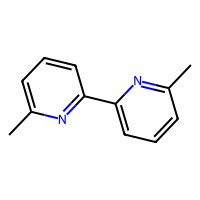
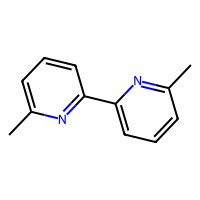
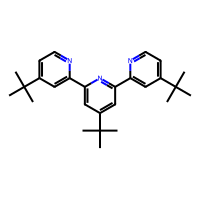
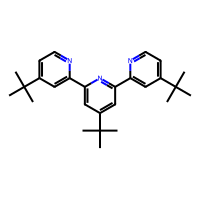
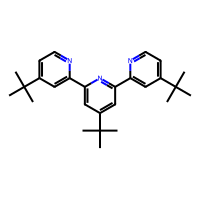
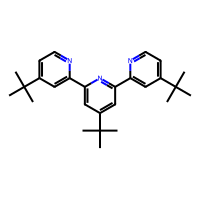
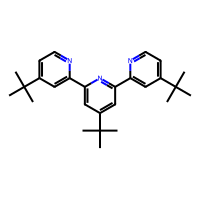

In [8]:
esol_data = pd.DataFrame(X_withSMILES['SMILES'])
PandasTools.AddMoleculeColumnToFrame(esol_data, smilesCol='SMILES')
esol_data

In [10]:
# Generate the Mordred descriptors for the whole dataset
if modred_data_path is not None:
    print('Loading Mordred data from file')
    mordred_data = pd.read_csv(modred_data_path)
    mordred_data.reset_index(drop=True)
    mordred_data = mordred_data.dropna(axis='columns')
    print(mordred_data.dtypes)
    print(mordred_data)
    print(mordred_data['SRW10'].values)
    mordred_data
#else:
#mordred_data = calc.pandas(esol_data['ROMol'])
#mordred_data = mordred_data.dropna(axis='columns')
#mordred_data.dtypes
# mordred_data = mordred_data.drop(['ABC', 'ABCGG'], axis=1)

Loading Mordred data from file
ABC         float64
ABCGG       float64
nAcid         int64
nBase         int64
SpAbs_A     float64
             ...   
WPol          int64
Zagreb1     float64
Zagreb2     float64
mZagreb1    float64
mZagreb2    float64
Length: 1826, dtype: object
           ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0    10.784941   9.210281      0      0  17.820064  2.325836  4.651672   
1    10.784941   9.210281      0      0  17.820064  2.325836  4.651672   
2    10.784941   9.210281      0      0  17.820064  2.325836  4.651672   
3    10.784941   9.210281      0      0  17.820064  2.325836  4.651672   
4    10.784941   9.210281      0      0  17.820064  2.325836  4.651672   
..         ...        ...    ...    ...        ...       ...       ...   
499  23.791976  19.094269      0      0  36.129301  2.457256  4.914512   
500  23.791976  19.094269      0      0  36.129301  2.457256  4.914512   
501  23.791976  19.094269      0      0  36.129301  2.4

In [11]:
# Exclude data with 'number' dtype
numeric_cols = mordred_data.select_dtypes(exclude='number') #選擇資料框中所有 dtype 不是 number 的列。
mordred_data.drop(numeric_cols, axis=1, inplace=True) # 函數刪除 numeric_cols 列。
#print(mordred_data)
#print(X_withoutSMILES)
X_withoutSMILES.reset_index(drop=True, inplace=True) # 將 X_withoutSMILES 的索引重設為從 0 開始的整數索引。
#X_withoutSMILES.dropna(axis=1, inplace=True) # 函數刪除 X_withoutSMILES 列。
print(mordred_data.shape)
print(X_withoutSMILES.shape)
# Combined the X collected from the experiment with Mordred descriptors
X_combined = pd.concat([X_withoutSMILES, mordred_data], axis = 1) # 把9種reagents跟lab code 共十種跟modred合起來
print(X_combined)

(504, 1430)
(504, 10)
     Reagent1 (ul)  Reagent2 (ul)  Reagent3 (ul)  Reagent4 (ul)  \
0               28            126              4             41   
1              100              6             41             52   
2               14             88             18             80   
3               28             69             83             20   
4               50              3             89             58   
..             ...            ...            ...            ...   
499             87             87             11             14   
500              3             46             95             56   
501             57             88             36             19   
502            125             28             23             24   
503             54             28             62             55   

     Reagent5 (ul)  Reagent6 (ul)  Reagent7 (ul)  Reagent8 (ul)  \
0                0              0              0              0   
1                0              0      

## Sanity check with the dissimilarity matrix
不相似矩陣是一種用於衡量兩個數據點之間差異的矩陣。它可以用於各種機器學習任務，例如聚類和異常檢測。

在本例中，我們使用不相似矩陣來檢查數據的一致性。如果數據一致，則不相似矩陣中的對角線元素應該是 0，並且其他元素應該是非零的。
Done on the first 100 columns because the float64 dtype is infinite.

In [12]:
# Select the first 100 columns because dtype can't handle too much data
print(X_combined.isnull().values.any()) # Check if there is null
#X_combined = X_combined.drop(['ABC', 'ABCGG'], axis=1) # 3.9要開起來
subselected_X = X_combined.iloc[: , :100]
subselected_X

False


,Reagent1 (ul),Reagent2 (ul),Reagent3 (ul),Reagent4 (ul),Reagent5 (ul),Reagent6 (ul),Reagent7 (ul),Reagent8 (ul),Reagent9 (ul),lab_code,...,ATS0v,ATS1v,ATS2v,ATS3v,ATS4v,ATS5v,ATS6v,ATS7v,ATS8v,ATS0se
0,28,126,4,41,0,0,0,0,800,1,...,5941.836101,7319.566840,9902.047431,10092.331242,8639.950757,7587.900859,6168.320431,4268.553634,2084.455817,191.511032
1,100,6,41,52,0,0,0,0,800,1,...,5941.836101,7319.566840,9902.047431,10092.331242,8639.950757,7587.900859,6168.320431,4268.553634,2084.455817,191.511032
2,14,88,18,80,0,0,0,0,800,1,...,5941.836101,7319.566840,9902.047431,10092.331242,8639.950757,7587.900859,6168.320431,4268.553634,2084.455817,191.511032
3,28,69,83,20,0,0,0,0,800,1,...,5941.836101,7319.566840,9902.047431,10092.331242,8639.950757,7587.900859,6168.320431,4268.553634,2084.455817,191.511032
4,50,3,89,58,0,0,0,0,800,1,...,5941.836101,7319.566840,9902.047431,10092.331242,8639.950757,7587.900859,6168.320431,4268.553634,2084.455817,191.511032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,87,87,11,14,0,0,0,0,800,1,...,13252.829922,16953.283305,25868.174602,31846.739876,31409.927226,29272.003432,28226.920861,28996.910666,29549.124112,469.345080
500,3,46,95,56,0,0,0,0,800,1,...,13252.829922,16953.283305,25868.174602,31846.739876,31409.927226,29272.003432,28226.920861,28996.910666,29549.124112,469.345080
501,57,88,36,19,0,0,0,0,800,1,...,13252.829922,16953.283305,25868.174602,31846.739876,31409.927226,29272.003432,28226.920861,28996.910666,29549.124112,469.345080
502,125,28,23,24,0,0,0,0,800,1,...,13252.829922,16953.283305,25868.174602,31846.739876,31409.927226,29272.003432,28226.920861,28996.910666,29549.124112,469.345080


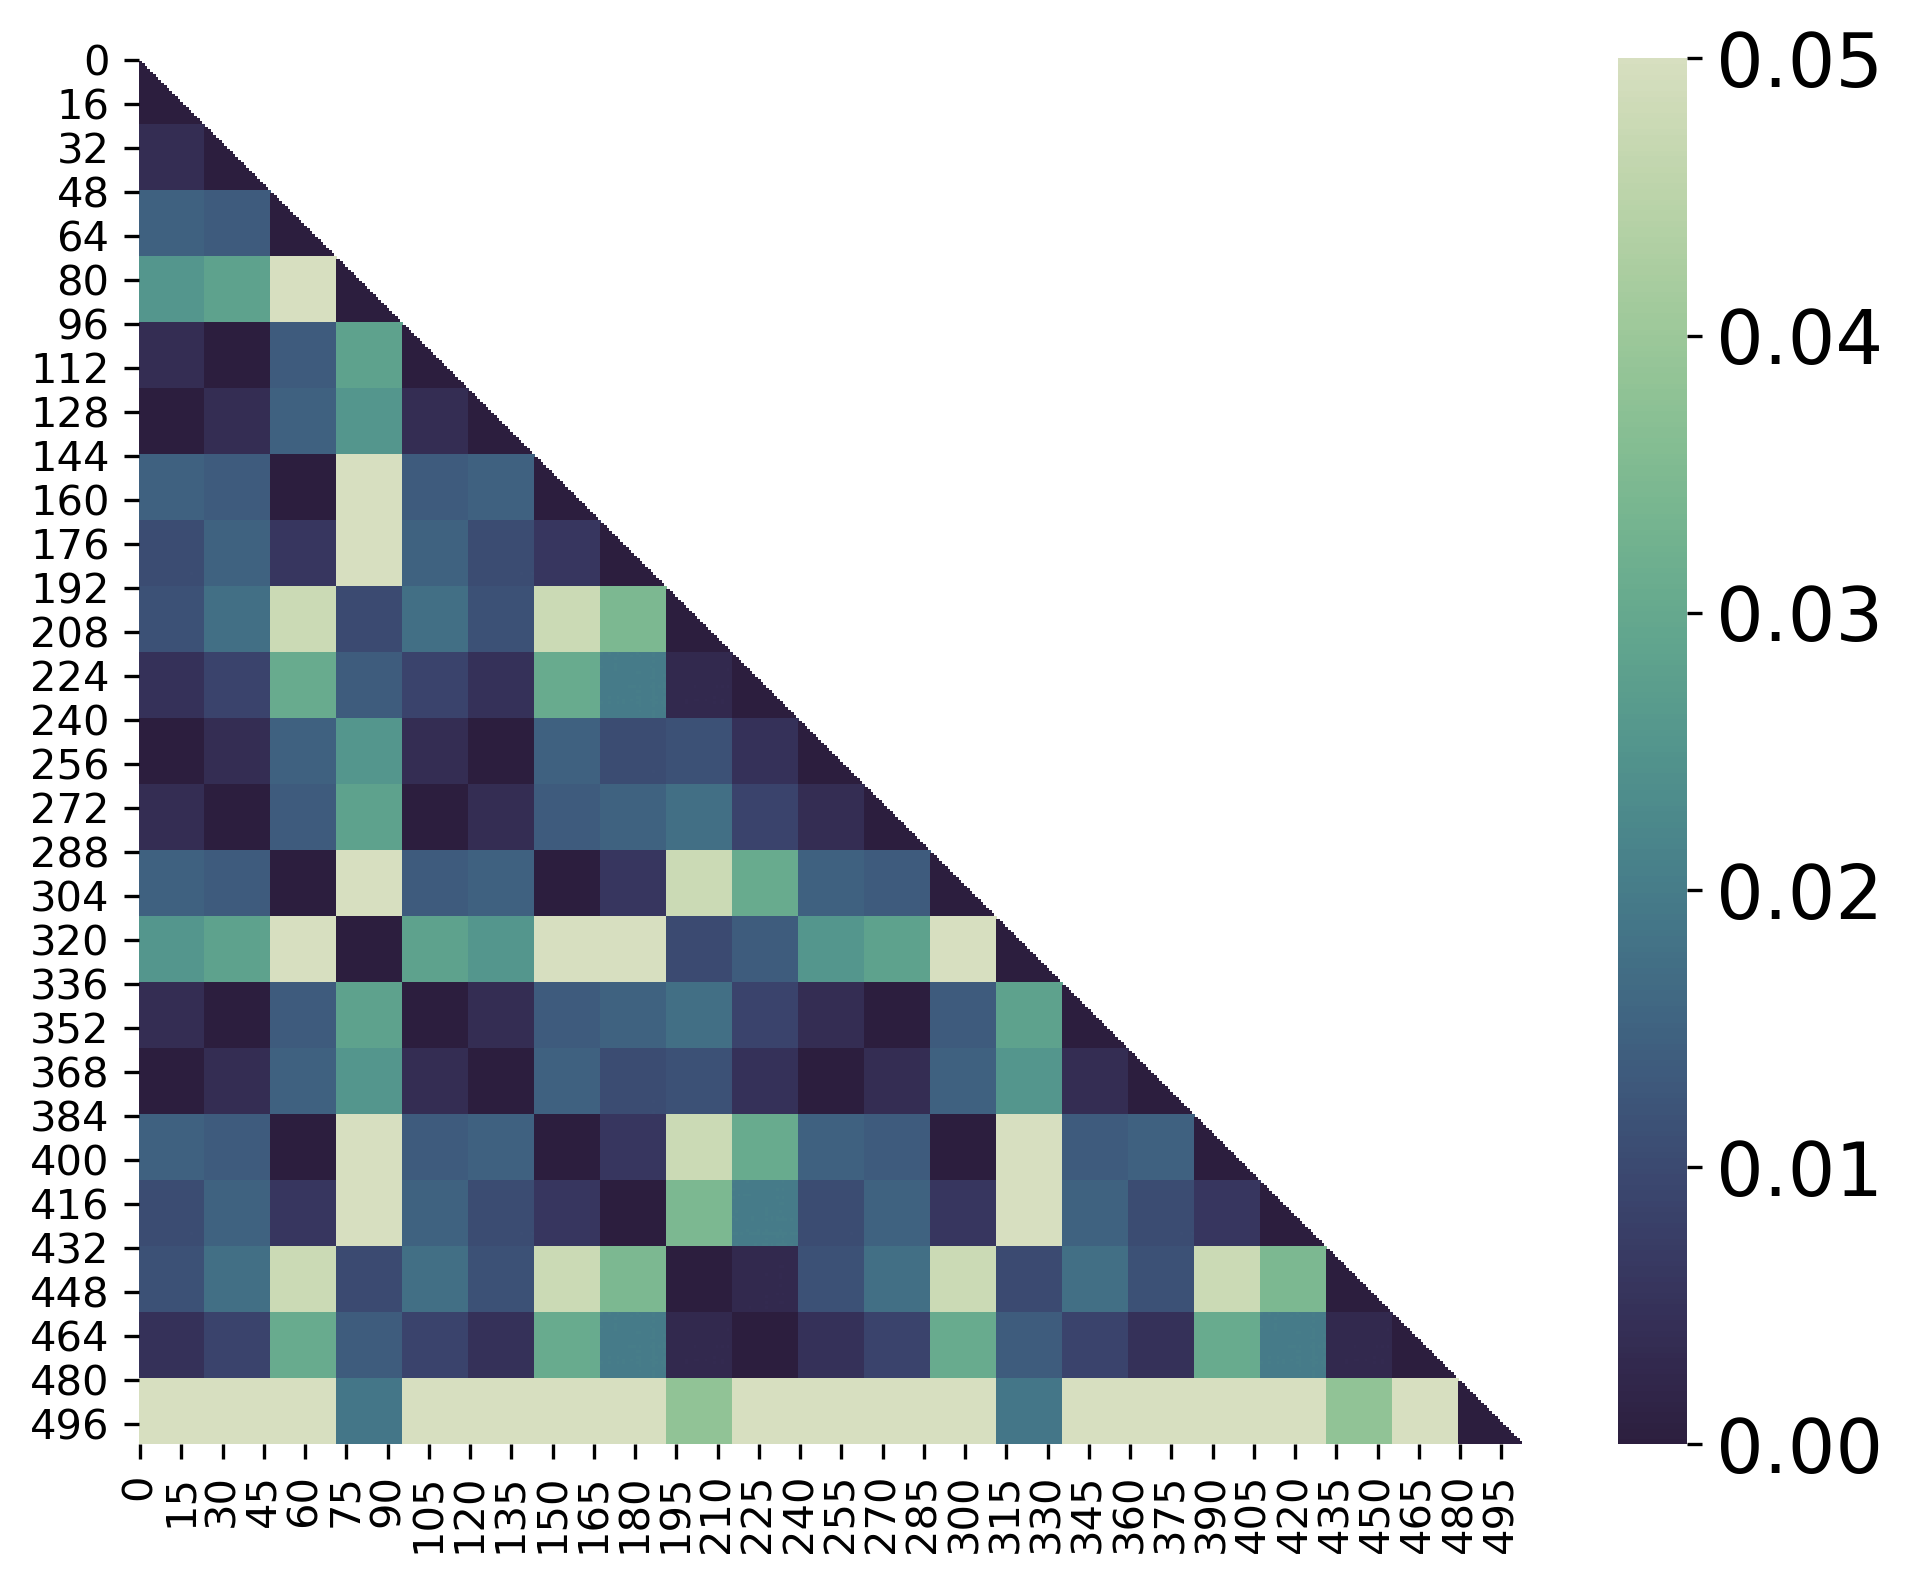

In [13]:
# Check the dissimilarity matrix of the dataset 
# 計算和可視化數據集的不相似矩陣的。
from sklearn.metrics.pairwise import pairwise_distances # 模塊包含用於計算成對距離的函數。
import seaborn as sns # 模塊是一個用于數據可視化的庫。

metric = 'cosine'

if metric=="cosine":
    cmap = sns.cubehelix_palette(start=.5, rot=-.75, reverse=True, as_cmap=True) # colormap for cosine
    colorMax = 0.05
    colorMin = 0
elif metric=="euclidean":
    cmap = sns.cubehelix_palette(as_cmap=True, reverse=True)
    colorMax = 1000
    colorMin = 0
else:
    cmap = sns.cubehelix_palette(start=2, rot=.25, reverse=True, as_cmap=True)
    colorMax = 30000
    colorMin = 0

d_absorber = pairwise_distances(subselected_X, metric=metric) # Calculating the pairwise distance

# Masking upper triangle
mask_ut = np.triu(np.ones_like(d_absorber,dtype=bool))    

# Visualizing dissimilarity matrix
fig = plt.figure(1,figsize=(8,6),dpi=300) # for all use 10,10; 8,6 for subsets
ax = fig.add_subplot(111)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 18 # for all: 20, 24 for subsets

ax = sns.heatmap(d_absorber, mask=mask_ut, cmap=cmap, vmax=colorMax,
            vmin=colorMin, square=True)
plt.show()

## Recursive feature elimination
看各個X是不是線性相依，Pearson Coef超過0.95就滾蛋
Now, we are starting to pick the features from our dataset.

### Excluding highly correlated features (> 95%)

In [14]:
# Import all the packages needed
from numpy import mean
from numpy import std
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

In [15]:
# Check the correlation matrix, to drop highly correlated features (above 0.95)
cor_matrix = X_combined.corr().abs()

# Masking the upper triangle
# upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool)) # 3.8
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool)) # 3.9


# Find which columns are to drop
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

# Drop the columns with high correlation
X_all_pre_noCorr = X_combined.drop(to_drop, axis=1)

# Save the dataset with dropped high correlation
X_all_pre_noCorr_complete = X_all_pre_noCorr.join(data_noAdditive['SMILES'])#,'crystal_score','crystal_size'])
X_all_pre_noCorr_complete = X_all_pre_noCorr_complete.join(data_noAdditive['crystal_score'])
X_all_pre_noCorr_complete = X_all_pre_noCorr_complete.join(data_noAdditive['crystal_size'])
X_all_pre_noCorr_complete.to_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/0_Create_Ground_Truth_Model/datasets/data_nocor2r.csv', index=False)

### Recursive Feature Elimination (RFE)

>4 -0.070 (0.036)
>8 -0.056 (0.025)
>12 -0.057 (0.027)
>16 -0.056 (0.025)
>20 -0.055 (0.024)


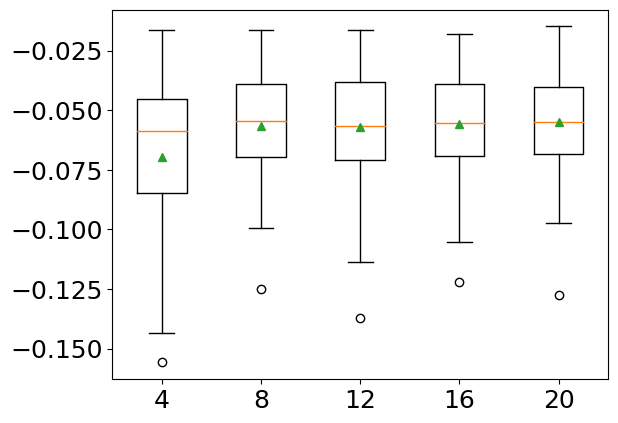

In [16]:
# Get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(4,21,4): # Can change the range of the RFE number of features to be evaluated
        rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=i)
#         model = RandomForestClassifier()
        model = RandomForestRegressor()
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models
 
# Evaluate any model using cross-validation
def evaluate_model(model, X, y):
#     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) # for classification
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1) # for regression
    
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# Get the models to evaluate
models = get_models()

# Evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_all_pre_noCorr, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# Plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

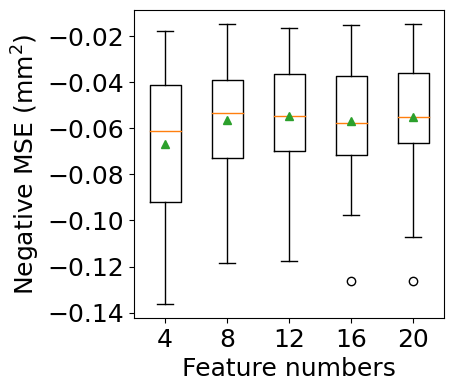

In [81]:
# Editing the figure with the labels

plt.figure(figsize=(4,4))
plt.boxplot(results, labels=names, showmeans=True)
font = {'family' : 'sans-serif',
#         'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)
plt.rcParams['figure.dpi'] = 300
plt.xlabel('Feature numbers')
# plt.ylim([-0.65,-0.025])
plt.ylabel('Negative MSE (mm$^2$)')
plt.show()

In [82]:
# Generating the dataframe with different feature numbers results
featureNum = [4,8,12,16,20]
resultDF = pd.DataFrame(results)
resultDF['featureNum'] = featureNum

# Rearranging columns
cols = resultDF.columns.tolist()
cols = cols[-1:] + cols[:-1]
resultDF = resultDF[cols]

In [83]:
# Based on the results, select the number of features which is the optimum
# In our case, n=8 is the optimum feature number
n = 8 # 這邊要改成自動判斷 是MSE最小的那一個較為合適

# Now, we go through RFE
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=n)
model = RandomForestRegressor()
pipe = Pipeline([('Feature Selection', rfe), ('Model', model)])

# We also do cross-validation
# In this case, we are using regression because we are training on continuous values
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1) # cross-validation for regression 

# Now, we look at the cross-validation score
n_scores = cross_val_score(pipe, X_all_pre_noCorr, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
np.mean(n_scores)

-0.06287275356132178

In [84]:
pipe.fit(X_all_pre_noCorr, y) # Fitting to the pipeline

Pipeline(steps=[('Feature Selection',
                 RFE(estimator=RandomForestRegressor(),
                     n_features_to_select=8)),
                ('Model', RandomForestRegressor())])

In [85]:
# Check which one is used and which one is dropped
pd.set_option('display.max_rows', None)
(pd.DataFrame(rfe.support_,index=X_all_pre_noCorr.columns,columns=['Rank']))

,Rank
Reagent1 (ul),True
Reagent2 (ul),True
Reagent3 (ul),True
Reagent4 (ul),True
Reagent5 (ul),False
Reagent6 (ul),False
Reagent7 (ul),False
Reagent8 (ul),False
Reagent9 (ul),False
lab_code,True


In [86]:
featuee_df = pd.DataFrame(rfe.support_,index=X_all_pre_noCorr.columns,columns=['Rank'])
featuee_df = featuee_df[featuee_df['Rank'] == True]
print(featuee_df.index)

Index(['Reagent1 (ul)', 'Reagent2 (ul)', 'Reagent3 (ul)', 'Reagent4 (ul)',
       'lab_code', 'AATS3i', 'AATSC5Z', 'AATSC7p'],
      dtype='object')


## Supervised learning: random forest regression

After we select the features and eliminate the rest of them, now we can start doing the supervised learning: random forest regression.

In [87]:
# Selected features
X_all_pre_noCorr_RFE = X_all_pre_noCorr.loc[:, rfe.support_]
X_all_pre_noCorr_RFE.head()

,Reagent1 (ul),Reagent2 (ul),Reagent3 (ul),Reagent4 (ul),lab_code,AATS3i,AATSC5Z,AATSC7p
0,28,126,4,41,1,159.729755,-0.732077,-0.054143
1,100,6,41,52,1,159.729755,-0.732077,-0.054143
2,14,88,18,80,1,159.729755,-0.732077,-0.054143
3,28,69,83,20,1,159.729755,-0.732077,-0.054143
4,50,3,89,58,1,159.729755,-0.732077,-0.054143


In [88]:
# Random Forest, choosing best parameters using GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [89]:
def rfr_model(X, y):
    
# Perform Grid-Search to find optimum parameter
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(1,10),
            'n_estimators': (5,10,20,30,40,50,60,70,80,90,100,500,1000),
        },
        cv=5, 
        scoring= 'neg_mean_squared_error', 
        verbose=0,
        n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],\
                                random_state=False, verbose=False)
    
# Perform K-Fold CV
    scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')#'neg_mean_absolute_error')

    return best_params
parameter_dict = rfr_model(X_all_pre_noCorr_RFE, y)
print('The best parameters: ',parameter_dict)

The best parameters:  {'max_depth': 9, 'n_estimators': 80}


In [90]:
parameter_dict

{'max_depth': 9, 'n_estimators': 80}

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error 
import pickle
max_depth = parameter_dict['max_depth']
n_estimators = parameter_dict['n_estimators']

# Now change this based on the best parameters above.
rf_regressor = RandomForestRegressor(max_depth =max_depth,n_estimators=n_estimators,
                                     random_state=1)

size_model_path = '/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/0_Create_Ground_Truth_Model/pvkadditives/pvk_rfr_size.pkl'

with open(size_model_path, 'rb') as f:
    rf_regressor = pickle.load(f)

# Fit to the training set
rf_regressor.fit(X_all_pre_noCorr_RFE, y)

# Perform predictions on both training and test sets
# y_train_hat = rf_regressor.predict(X_train_stand)
# y_test_hat = rf_regressor.predict(X_test_stand)
y_all_hat = rf_regressor.predict(X_all_pre_noCorr_RFE)

# View accuracy score

# accuracy_score(y_test, y_test_hat) # for classification
mse = mean_squared_error(y, y_all_hat)
mae = neg_mean_absolute_error(y, y_all_hat)
mean = np.mean(y)
rmse = np.sqrt(mse)
print(mse) # for regression
print(np.mean(cross_val_score(rf_regressor, X_all_pre_noCorr_RFE, y, cv=10, scoring='r2')))
print(rmse/mean)
print(mae)

NameError: name 'parameter_dict' is not defined

In [98]:
# A simple visulization functions

def prediction_vs_ground_truth_fig(y_train, y_train_hat, y_test, y_test_hat):
    from sklearn import metrics
    fontsize = 12
    plt.figure(figsize=(1.5,1.5))
    plt.rcParams['figure.dpi'] = 300
    plt.figure(figsize=(3,3))
    font = {'family' : 'sans-serif',
#         'weight' : 'bold',
            'size'   : 12}
    plt.rc('font', **font)
    a = plt.scatter(y_train, y_train_hat, s=25,c='#a2c898')
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k:', lw=1.5)
    plt.xlabel('Observation (mm)', fontsize=fontsize)
    plt.ylabel('Prediction (mm)', fontsize=fontsize)
    plt.tick_params(direction='out')
#     plt.title(('Train RMSE: {:.2e}'.format(np.sqrt(metrics.mean_squared_error(y_train, y_train_hat))),\
#                'Test RMSE: {:.2e}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_test_hat)))), fontsize=fontsize)
    print(('Train RMSE: {:.2e}'.format(np.sqrt(metrics.mean_squared_error(y_train, y_train_hat))),
               'Test RMSE: {:.2e}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_test_hat)))))
    b = plt.scatter(y_test, y_test_hat, s=25,c='#427883')
#     plt.legend((a,b),('Train','Test'),fontsize=fontsize,handletextpad=0.1,borderpad=0.1,frameon=False)
    plt.tight_layout()
#     plt.show()

('Train RMSE: 1.06e-01', 'Test RMSE: 1.06e-01')


<Figure size 450x450 with 0 Axes>

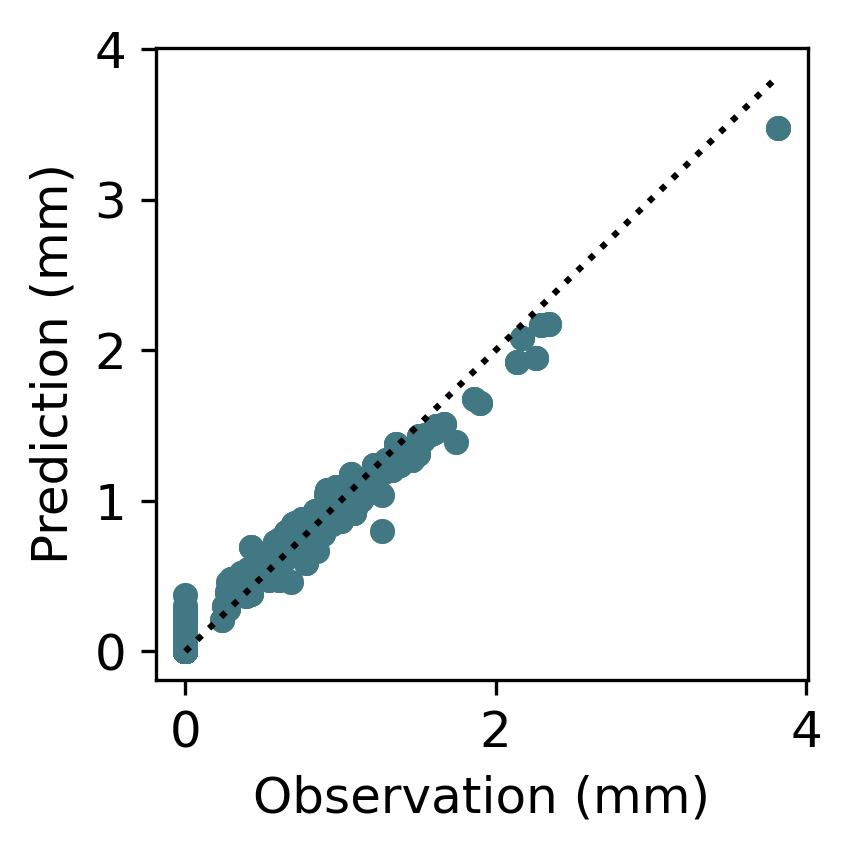

In [99]:
# Visualize the results for regression
prediction_vs_ground_truth_fig(y, y_all_hat, y, y_all_hat)

In [44]:
import pickle

# Save Model
with open(os.path.join(os.getcwd(),f'{environment_name}/pvk_rfr_size.pkl'), "wb") as f:
    pickle.dump(rf_regressor, f)

In [9]:
# another plot
from sklearn.ensemble import RandomForestRegressor
# from rdkit.Chem import PandasTools
import pickle
from sklearn.metrics import r2_score
import pandas as pd
from mordred import Calculator, descriptors
from rdkit import Chem

size_model_path = '/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/0_Create_Ground_Truth_Model/pvkadditives/pvk_rfr_size.pkl'

with open(size_model_path, 'rb') as f:
    rf_regressor = pickle.load(f)

data = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/0_Create_Surrogate_Model/combined_compiledData_wmol.csv')
y = data['crystal_size']

df = pd.DataFrame(data)
# modred feature calculating
calc = Calculator(descriptors, ignore_3D=True)
smiles_list = list(df['SMILES'])
mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]
mordred_df = calc.pandas(mols)

cols_to_convert = ['ATSC5v', 'AATSC5Z', 'MATS8se']

df = pd.concat((df, mordred_df['ATSC5v'] ,mordred_df['AATSC5Z'], mordred_df['MATS8se']), axis=1)

pvk_size_feature_list = ['Reagent1 (ul)','Reagent2 (ul)','Reagent3 (ul)','Reagent4 (ul)','lab_code','ATSC5v', 'AATSC5Z', 'MATS8se']

# 縮減 X 到只包含前五十個特徵
# X_reduced = X[list(features)]

X_reduced = df[pvk_size_feature_list]

# 進行交叉驗證
scores = cross_val_score(rf_regressor, X_reduced, y, cv=5, scoring='r2')

# 計算 R^2 的平均值
average_r2 = np.mean(scores)

# 打印 R^2 的平均值
print('Average R^2:', average_r2)

# 計算平均交叉驗證分數和標準差
mean = np.mean(scores)
std = np.std(scores)

# 打印模型名稱和交叉驗證分數
print(f'Model: RandomForestRegressor\nCross-validation scores: {scores}')
y_pred = rfr.predict(X_reduced)
r2 = r2_score(y, y_pred)
plt.figure(figsize=(10, 8), dpi=400)
plt.scatter(y, y_pred, alpha=0.8, color='#0F5257', s=20)  # 調整點的顏色為 'darkorange'，大小為 80
plt.xlabel('Experiment Value (Percentage)')
plt.ylabel('Prediction Value (Percentage)')

# 繪製圖表
plt.plot([0, 100], [0, 100], color='#0B3142')  # 調整對角線的顏色為 'skyblue'
plt.title(f'RandomForestRegressor for Crystal Size Prediction (8 features)')
plt.text(0.02, 0.91, f'Regression $R^2$: {r2:.4f}\nMean cross-validation score: {mean:.4f}\nStandard deviation: {std:.4f}', transform=plt.gca().transAxes)
plt.xlim(0, 100)
plt.ylim(0, 100)
#plt.savefig(f'/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/Regression_Model_Analysis/Parity_plot_RandomForestRegressor_50_features.png')

  2%|▏         | 12/528 [00:01<01:59,  4.33it/s]OpenBLAS blas_thread_init: pthread_create failed for thread 13 of 64: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 4096 current, 497655 max
OpenBLAS blas_thread_init: pthread_create failed for thread 14 of 64: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 4096 current, 497655 max
OpenBLAS blas_thread_init: pthread_create failed for thread 15 of 64: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 4096 current, 497655 max
OpenBLAS blas_thread_init: pthread_create failed for thread 16 of 64: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 4096 current, 497655 max
OpenBLAS blas_thread_init: pthread_create failed for thread 17 of 64: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 4096 current, 497655 max
OpenBLAS blas_thread_init: pthread_create failed for thread 18 of 64: Resource temporarily unavailable
OpenBLAS 

KeyboardInterrupt: 

## Shapley value analysis

Now, we can do the feature importance rank using Shapley value analysis (https://github.com/slundberg/shap).

In [45]:
import shap

# Use shap to explain our rf_regressor
explainerRF = shap.TreeExplainer(rf_regressor, check_additivity=False)

# Get standardized X Dataframe
X_stand_df = X_all_pre_noCorr_RFE
shap_values_RF_test = explainerRF.shap_values(X_all_pre_noCorr_RFE)

/home/chenyo/anaconda3/envs/pvkadditives/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


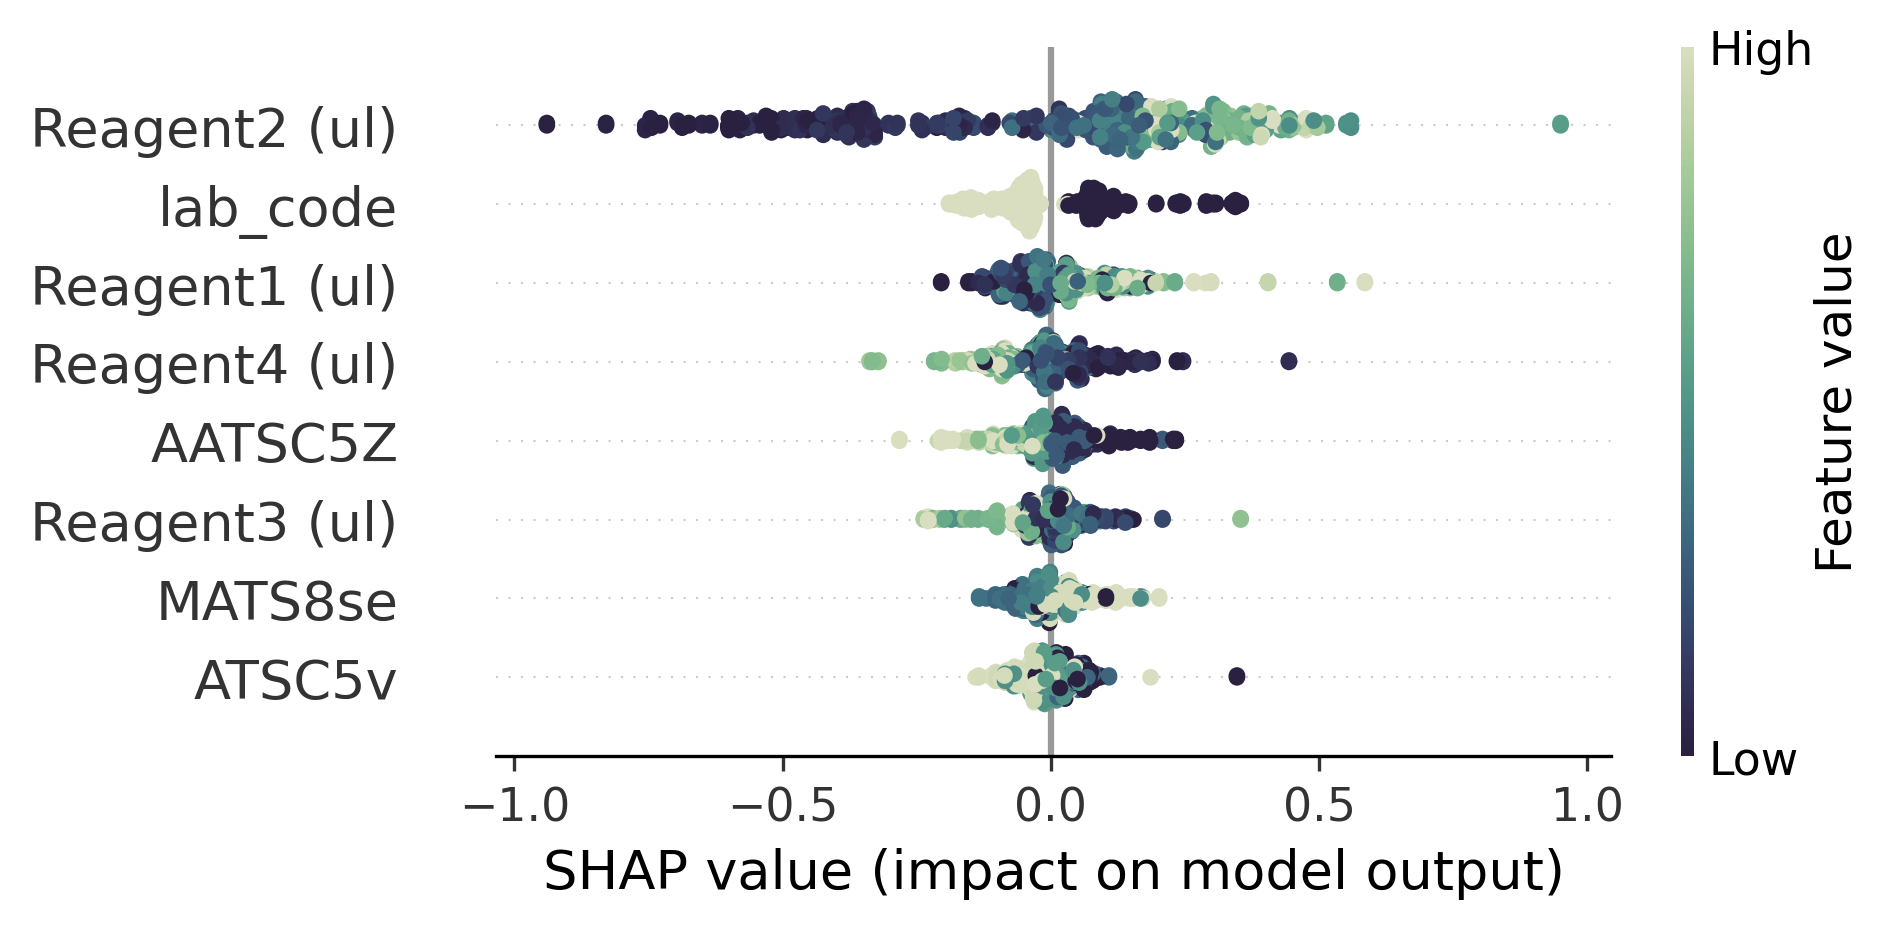

In [46]:
# Plot SHAP figure
plt.figure()
shap.summary_plot(shap_values_RF_test, X_stand_df,plot_type = "dot",
                            #color=plt.get_cmap("plasma"),
                           show = False)
# plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 60})
plt.rcParams['figure.dpi'] = 300

# Change the colormap of the artists, UNCOMMENT FOR DEFAULT COLORMAP
# my_cmap = plt.get_cmap('viridis')
cmap = sns.cubehelix_palette(start=.45, rot=-.75, reverse=True, as_cmap=True)
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(cmap)

# plt.show()
plt.tight_layout()

# UNCOMMENT TO SAVE A FIGURE
# plt.savefig('20211007_rf_nonstand_shap_264datapoints_median_4.png', dpi = 1200)

In [47]:
# In the last part i wnat to notice that x type and y type
print(type(X_all_pre_noCorr_RFE), type(y))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


# Create Score Ground Truth Model from the Pvk experiment data

In [48]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

>2 0.848 (0.051)
>4 0.941 (0.036)
>6 0.947 (0.033)
>8 0.944 (0.031)


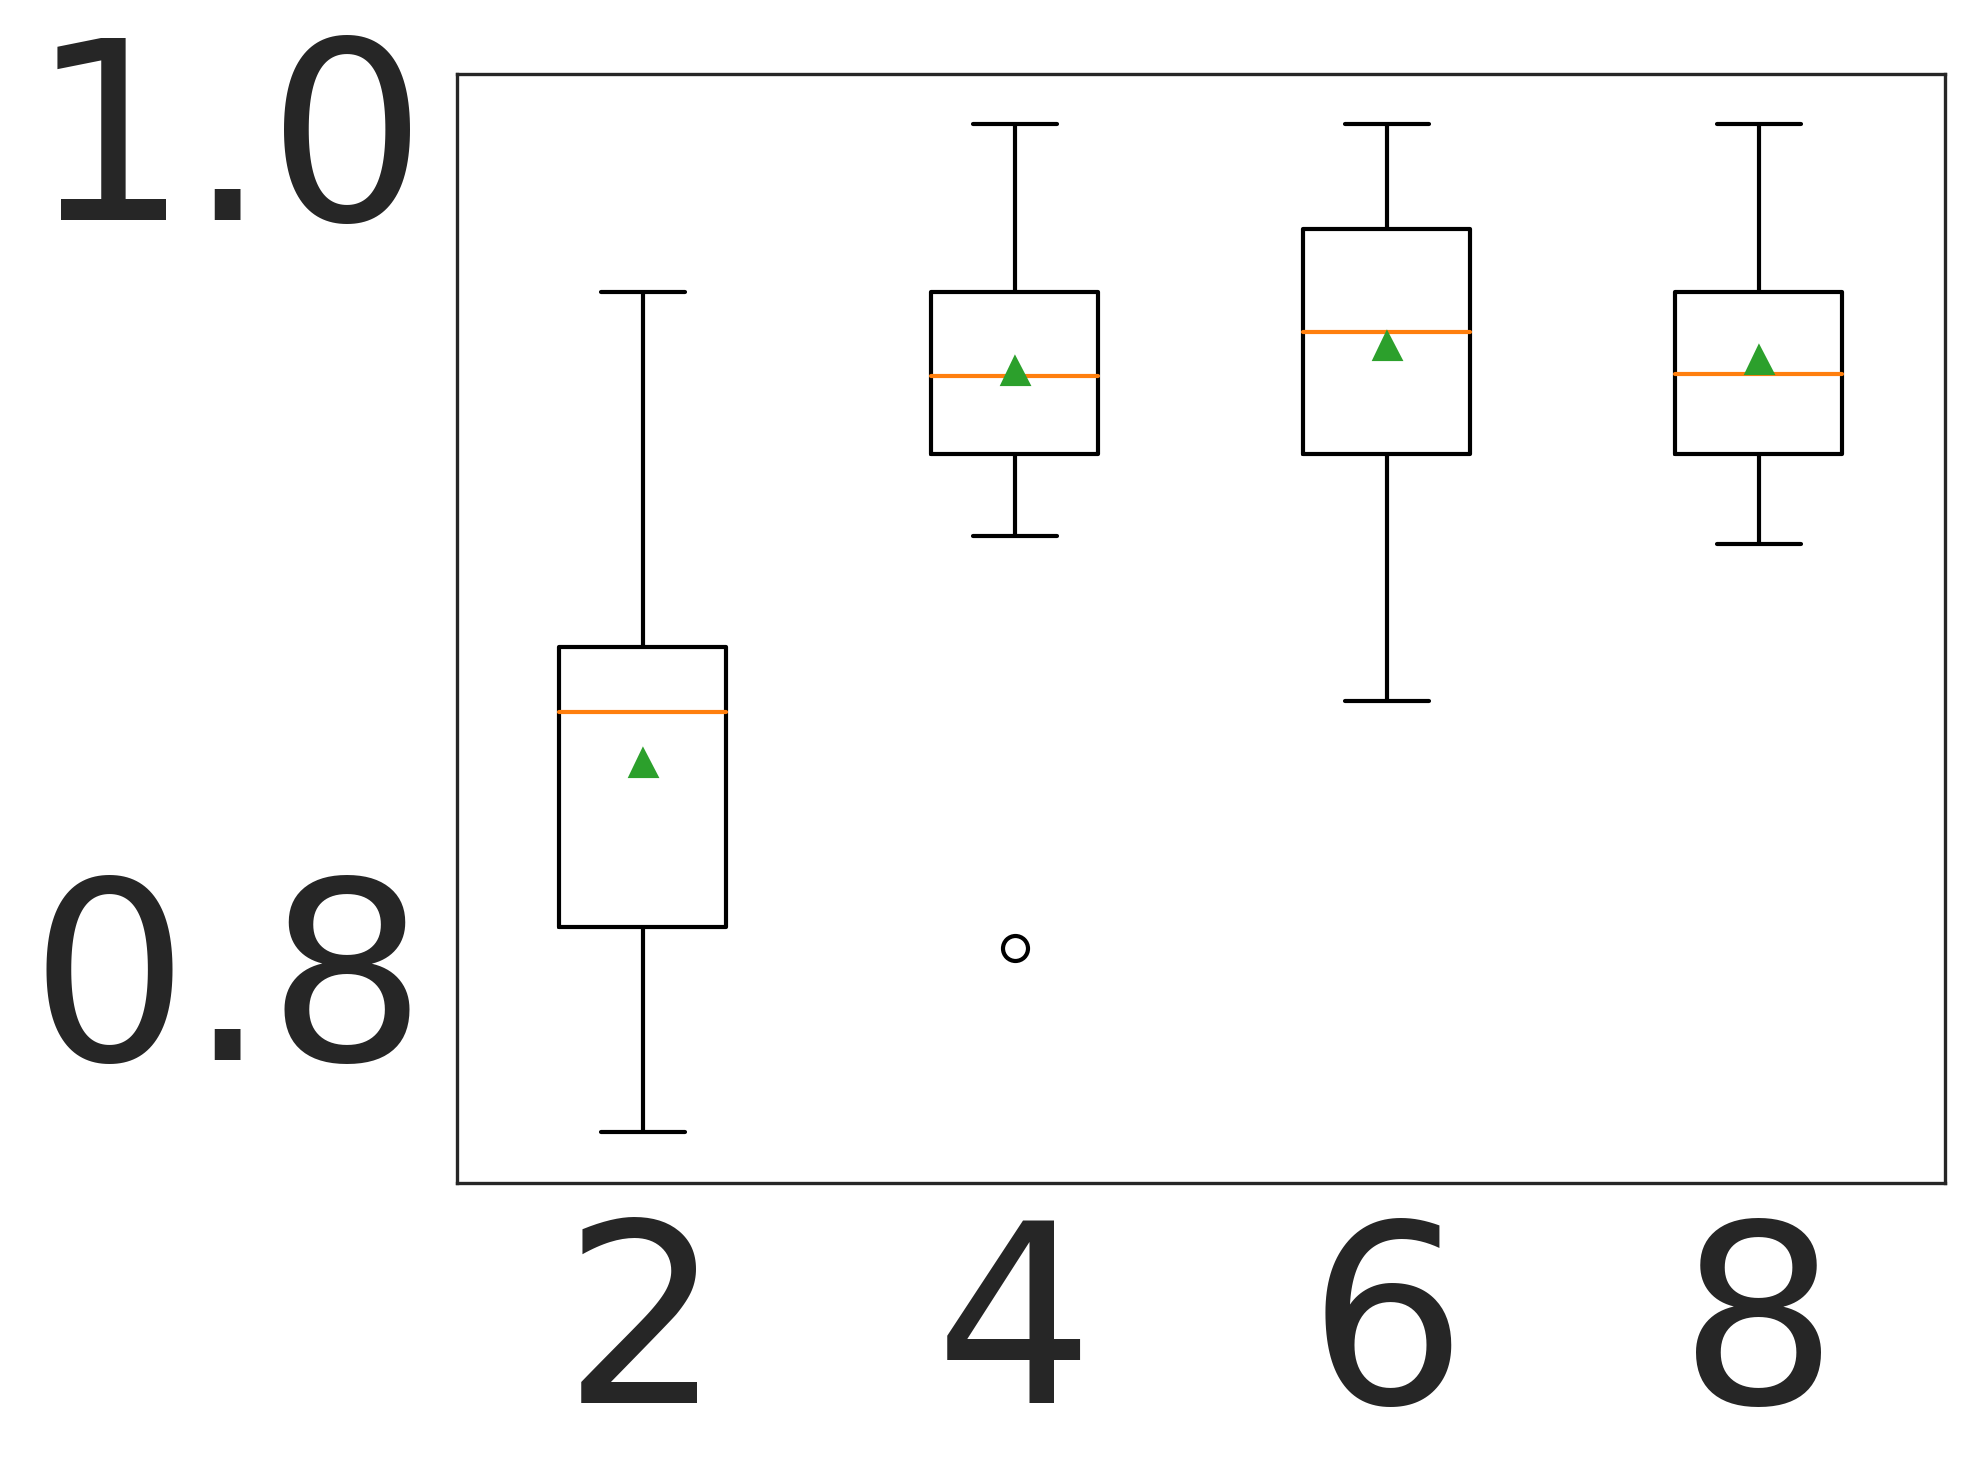

In [49]:
# Get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(2,9,2):
        rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=i) # Because we're doing classification
        model = RandomForestClassifier()
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models
 
# Evaluate any given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) # For classification
    
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise') # For classification
   
    return scores

# Get the models to evaluate
models = get_models()

# Evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_all_pre_noCorr, y_score)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# Plot model performance for comparison
sns.set_style('white')
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

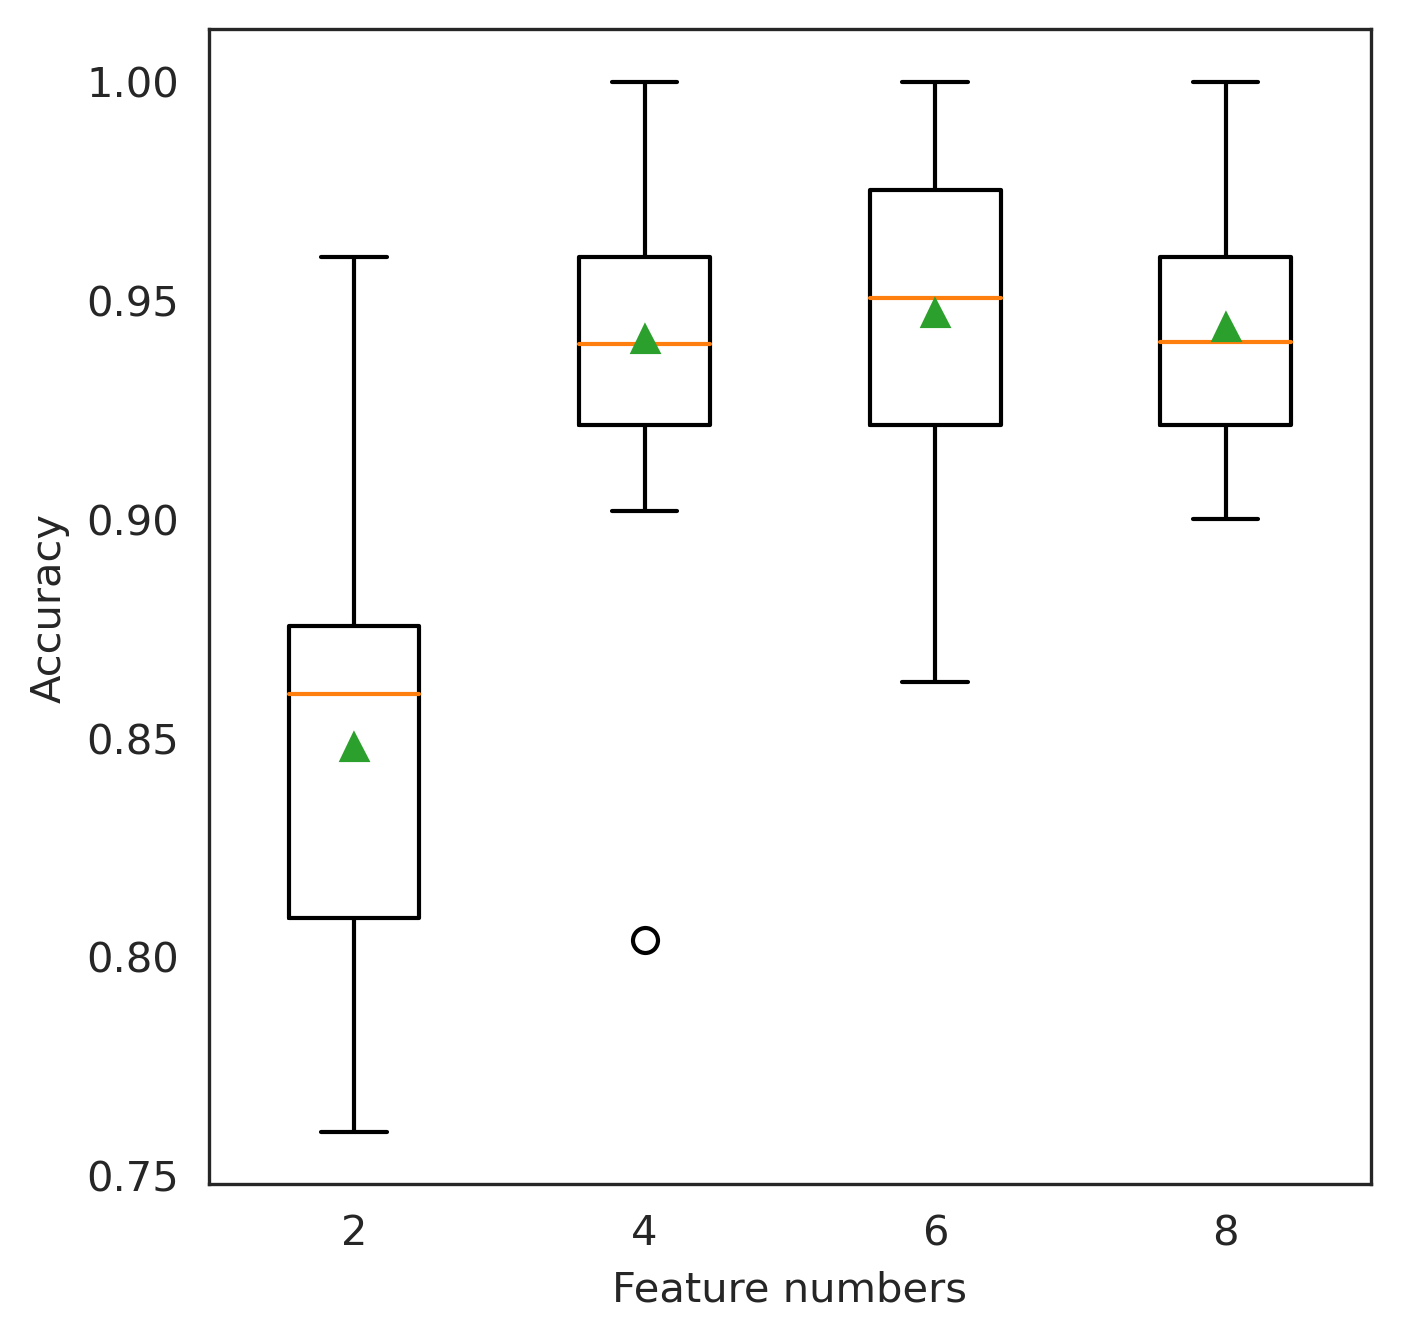

In [63]:
# Edit the plot so that it looks good
plt.figure(figsize=(5,5))
sns.set_style('white')
plt.boxplot(results, labels=names, showmeans=True)
font = {'family' : 'sans-serif',
#         'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.rcParams['figure.dpi'] = 300
plt.xlabel('Feature numbers')
plt.ylabel('Accuracy')
plt.show()

In [51]:
# Let's pick a certain number of features and see how it performs
n = 6

# Now, we go through RFE
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=n)
model = RandomForestClassifier()
pipe = Pipeline([('Feature Selection', rfe), ('Model', model)])

# We also do cross-validation
# cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1) # For regression
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=2)

# Now, we look at the cross-validation score
# n_scores = cross_val_score(pipe, X_all_pre_noCorr, y_binary, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1) # For regression
n_scores = cross_val_score(pipe, X_all_pre_noCorr, y_score, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.944792156862745

In [52]:
pipe.fit(X_all_pre_noCorr, y_score) # Fitting to the pipeline
# Check which one is used and which one is dropped
pd.set_option('display.max_rows', None)
(pd.DataFrame(rfe.support_,index=X_all_pre_noCorr.columns,columns=['Rank']))

,Rank
Reagent1 (ul),True
Reagent2 (ul),True
Reagent3 (ul),True
Reagent4 (ul),True
Reagent5 (ul),False
Reagent6 (ul),False
Reagent7 (ul),False
Reagent8 (ul),False
Reagent9 (ul),False
lab_code,False


In [53]:
featuee_df = pd.DataFrame(pd.DataFrame(rfe.support_,index=X_all_pre_noCorr.columns,columns=['Rank']))
featuee_df = featuee_df[featuee_df['Rank'] == True]
print(featuee_df.index)

Index(['Reagent1 (ul)', 'Reagent2 (ul)', 'Reagent3 (ul)', 'Reagent4 (ul)',
       'AATS2p', 'ATSC5Z'],
      dtype='object')


In [54]:
# Selected features
X_all_pre_noCorr_RFE = X_all_pre_noCorr.loc[:, rfe.support_]
X_all_pre_noCorr_RFE.head()

,Reagent1 (ul),Reagent2 (ul),Reagent3 (ul),Reagent4 (ul),AATS2p,ATSC5Z
0,28,126,4,41,1.610779,-31.47929
1,100,6,41,52,1.610779,-31.47929
2,14,88,18,80,1.610779,-31.47929
3,28,69,83,20,1.610779,-31.47929
4,50,3,89,58,1.610779,-31.47929


In [55]:
# Random Forest, choosing best parameters using GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler 

def rfr_model(X, y):
    
# Perform Grid-Search to find optimum parameter
    gsc = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid={
            'max_depth': range(1,20),
            'n_estimators': (1,2,3,4,5,10,20,30,40,50,60,70,80,90,100,500,1000),
        },
        cv=5, 
        scoring= 'accuracy',
        verbose=0,
        n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rfr = RandomForestClassifier(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],\
                                random_state=False, verbose=False)
    
# Perform K-Fold CV
#     scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')#'neg_mean_absolute_error')
    scores = cross_val_score(rfr, X, y, cv=10, scoring='accuracy')#'neg_mean_absolute_error')

    return best_params
feature_dict = rfr_model(X_all_pre_noCorr_RFE,y_score)
print('The best parameters: ',feature_dict)

The best parameters:  {'max_depth': 14, 'n_estimators': 40}


## Change the random forest classifier parameter.

In [56]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error

# rf_regressor = RandomForestRegressor(n_estimators=10,
#                                      max_depth =7,
#                                      random_state=1) # For regression

# Now change this based on the best parameters above
rf_classifier = RandomForestClassifier(max_depth = feature_dict['max_depth'], n_estimators = feature_dict['n_estimators'],
                                       random_state=1)

# Fit to the training set
rf_classifier.fit(X_all_pre_noCorr_RFE,y_score)

# Perform predictions on both training and test sets
y_all_hat = rf_classifier.predict(X_all_pre_noCorr_RFE)

# Visualize the results for regression
# prediction_vs_ground_truth_fig(y_train, y_train_hat, y_test, y_test_hat) # this one is for regression
# rf_regressor.feature_importances_

# Visualize confusion matrix for classification
cf_matrix = confusion_matrix(y_score, y_all_hat)
print(cf_matrix)

[[ 42   0   0   0]
 [  0  19   0   0]
 [  0   0  75   0]
 [  0   0   0 368]]


In [57]:
accuracy_score(y_score, y_all_hat)

with open(os.path.join(os.getcwd(),f'{environment_name}/pvk_rfc_score.pkl'), "wb") as f:
    pickle.dump(rf_classifier, f)

[['42\n8.33%' '0\n0.00%' '0\n0.00%' '0\n0.00%']
 ['0\n0.00%' '19\n3.77%' '0\n0.00%' '0\n0.00%']
 ['0\n0.00%' '0\n0.00%' '75\n14.88%' '0\n0.00%']
 ['0\n0.00%' '0\n0.00%' '0\n0.00%' '368\n73.02%']]


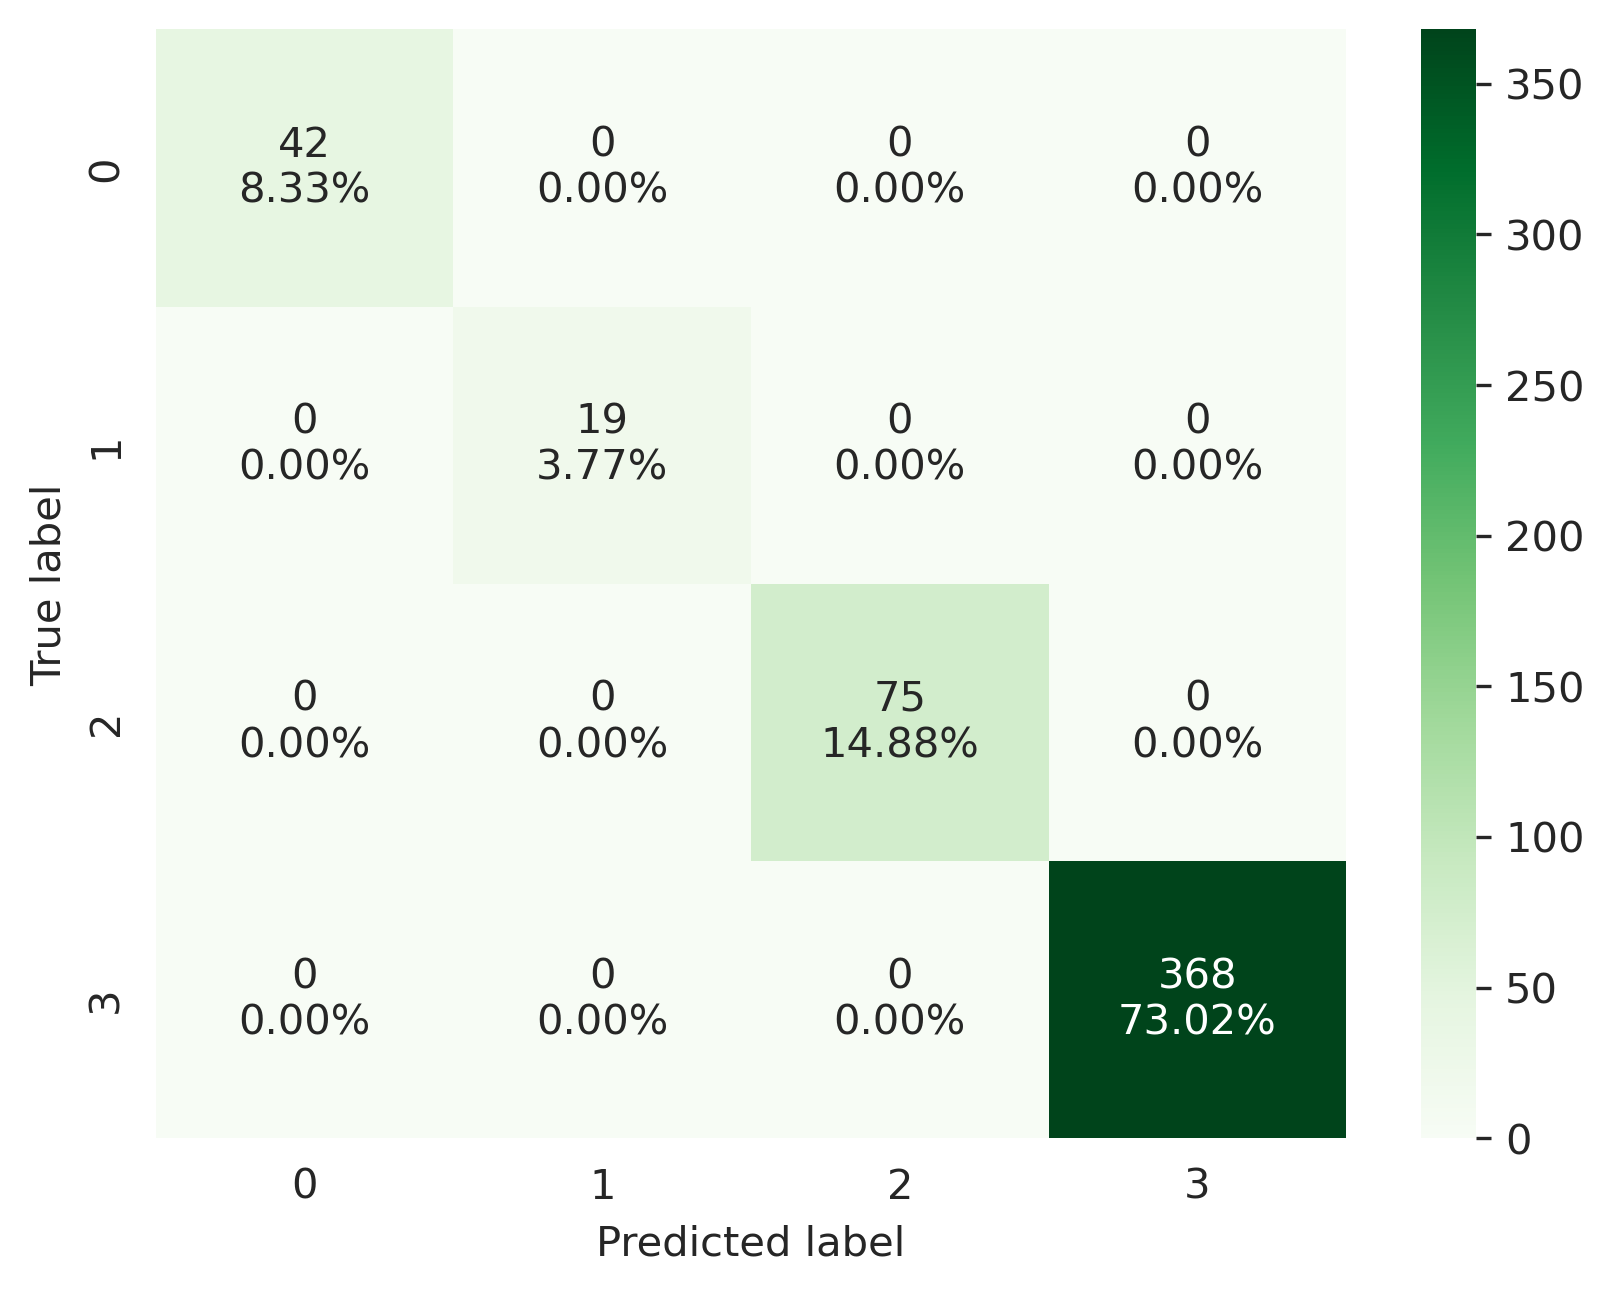

In [58]:
# Visualize the result
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# For non-binary classification:
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(4, 4)
print(labels)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens')
plt.xlabel('Predicted label')
plt.ylabel('True label')
font = {'family' : 'sans-serif'}

plt.rc('font', **font)
plt.show()

# For binary classification

# plt.figure(figsize=(5,4))
# plt.rcParams['figure.dpi'] = 300

# group_counts = ["{0:0.0f}".format(value) for value in
#                 cf_matrix.flatten()]
# group_percentages = ["{0:.2%}".format(value) for value in
#                      cf_matrix.flatten()/np.sum(cf_matrix)]
# labels = [f"{v1}\n{v2}" for v1, v2 in
#           zip(group_counts,group_percentages)]

# labels = np.asarray(labels).reshape(2,2)
# sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues') # Plotting confusion matrix
# plt.xlabel('Predicted label')
# plt.ylabel('True label')

# font = {'family' : 'Arial',
# #         'weight' : 'bold',
#         'size'   : 18}

# plt.rc('font', **font)
# plt.show()